In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from stockfish import Stockfish
import chess
import chess.engine
import math

In [2]:
engine = chess.engine.SimpleEngine.popen_uci("C:/Users/meinzecp/Downloads/stockfish_14.1_win_x64_avx2/stockfish_14.1_win_x64_avx2.exe")
stockfish = Stockfish('C:/Users/meinzecp/Downloads/stockfish_14.1_win_x64_avx2/stockfish_14.1_win_x64_avx2.exe')
stockfish.set_elo_rating(2600)
df = pd.read_csv('./chess_subsample.csv')

In [3]:
print(df.dtypes)
df.head(1)

game_id               int64
rated                  bool
turns                 int64
victory_status       object
winner               object
time_increment       object
white_id             object
white_rating          int64
black_id             object
black_rating          int64
moves                object
opening_code         object
opening_moves         int64
opening_fullname     object
opening_shortname    object
opening_response     object
opening_variation    object
dtype: object


,game_id,rated,turns,victory_status,winner,time_increment,white_id,white_rating,black_id,black_rating,moves,opening_code,opening_moves,opening_fullname,opening_shortname,opening_response,opening_variation
0,1,False,13,Out of Time,White,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,5,Slav Defense: Exchange Variation,Slav Defense,NaN,Exchange Variation


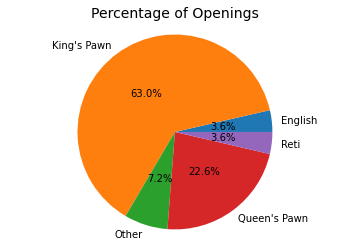

<Figure size 432x288 with 0 Axes>

In [4]:
# Getting rid of all of the games that are only a few moves
df = df[df.turns >= 3]

# Making a new Series in the dataframe to contain a list of all the moves, since the move list as a string is not all that useful to us
df['moves_list'] = df.moves.apply(lambda x: x.split())

# Add columns called opening_move and response, which are the first moves by white and black, respectively
df['opening_move'] = df.moves_list.apply(lambda x: x[0])
df['response'] = df.moves_list.apply(lambda x: x[1])

# Adding an opening_name column to name a few common opening moves
df['opening_name'] = df.moves_list.apply(lambda x: 'King\'s Pawn' 
                                         if x[0] == 'e4' 
                                         else ('Queen\'s Pawn' 
                                               if x[0] == 'd4' 
                                               else ('English' 
                                                     if x[0] == 'c4' 
                                                     else ('Reti' 
                                                           if x[0] == 'Nf3' 
                                                           else 'Other'))))

# What was the rating gap between the two players?
df['rating_gap'] = abs(df['white_rating'] - df['black_rating'])

# Did the higher-rated player win?
df['higher_rated_victory'] = np.where((df['winner'] == 'White') & (df['white_rating'] > df['black_rating']) | (df['winner'] == 'Black') & (df['black_rating'] > df['white_rating']), 1, 0)

# Classify the rating gap. This will be used later when we want to visualize what affect greater rating gaps have on the victory rate of higher-rated players
df['rating_gap_class'] = df.rating_gap.apply(lambda x: '0-50' 
                                             if (x <= 50) 
                                             else ('51-100' 
                                                   if (x > 50 and x <= 100) 
                                                   else ('101-150' 
                                                         if (x > 100 and x <= 150) 
                                                         else ('151-200' 
                                                               if (x > 150 and x <= 200) 
                                                               else ('201-250' 
                                                                     if (x > 200 and x <= 250) 
                                                                     else '>250')))))

# Did white win?
df['white_victory'] = np.where(df['winner'] == 'White', 1, 0)

# Split into four of the most popular openings by white
english = df[df.opening_move == 'c4']
queens_pawn = df[df.opening_move == 'd4']
kings_pawn = df[df.opening_move == 'e4']
reti = df[df.opening_move == 'Nf3']

# Visualize which openings are used the most
opening_data = df.groupby('opening_name')['game_id'].count()
plt.pie(x=opening_data, 
        autopct='%.1f%%', 
        labels=opening_data.keys(), 
        pctdistance=0.5)
plt.title('Percentage of Openings', fontsize=14)
plt.axis('equal')
plt.show()
plt.clf()

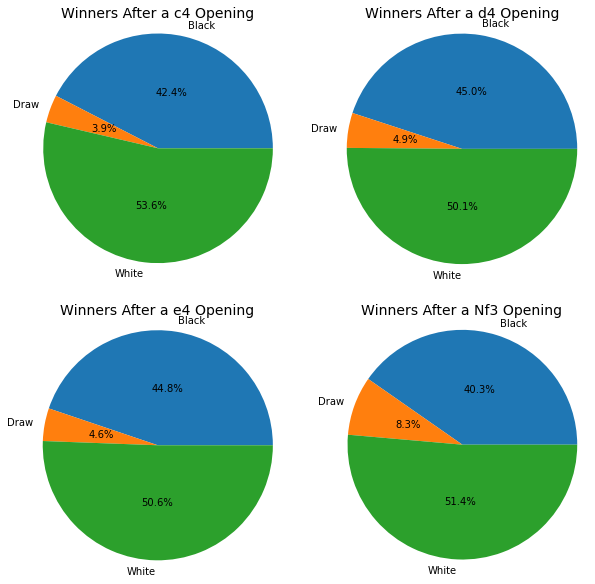

In [5]:
# Visualize who was able to win after each opening using pie chart

# For each DataFrame, create additional DataFrame counting the number of times white or black won (or drew)
english_winner_data = english.groupby('winner')['game_id'].count()
queen_winner_data = queens_pawn.groupby('winner')['game_id'].count()
king_winner_data = kings_pawn.groupby('winner')['game_id'].count()
reti_winner_data = reti.groupby('winner')['game_id'].count()

pie, axs = plt.subplots(2,2, figsize=[10,10])

plt.subplot(2,2,1)
plt.pie(x=english_winner_data, 
        autopct="%.1f%%", 
        labels=english_winner_data.keys(), 
        pctdistance=0.5)
plt.title("Winners After a c4 Opening", fontsize=14)
plt.axis('equal')

plt.subplot(2,2,2)
plt.pie(x=queen_winner_data, 
        autopct="%.1f%%", 
        labels=queen_winner_data.keys(), 
        pctdistance=0.5)
plt.title("Winners After a d4 Opening", fontsize=14)
plt.axis('equal')

plt.subplot(2,2,3)
plt.pie(x=king_winner_data, 
        autopct="%.1f%%", 
        labels=king_winner_data.keys(), 
        pctdistance=0.5)
plt.title("Winners After a e4 Opening", fontsize=14)
plt.axis('equal')

plt.subplot(2,2,4)
plt.pie(x=reti_winner_data, 
        autopct="%.1f%%", 
        labels=reti_winner_data.keys(), 
        pctdistance=0.5)
plt.title("Winners After a Nf3 Opening", fontsize=14)
plt.axis('equal')
plt.show()

In [6]:
# Creating a DataFrame to tell me the total amount of wins by the white pieces in four common openings

# Counts the total amount of white piece victories, grouped by opening name
df_grouped_ratings = df.groupby('opening_name')['higher_rated_victory'].sum()
df_grouped_ratings = df_grouped_ratings.to_frame() #Converting from series to dataFrame

# Adding a column for the total number of games
df_grouped_ratings['totals'] = df.groupby('opening_name')['higher_rated_victory'].count()
# Adding a column for draws/losses
df_grouped_ratings['losses_or_draws'] = df_grouped_ratings['totals'] - df_grouped_ratings['higher_rated_victory']
print(df_grouped_ratings.head(10))

              higher_rated_victory  totals  losses_or_draws
opening_name                                               
English                        426     714              288
King's Pawn                   7626   12499             4873
Other                          915    1434              519
Queen's Pawn                  2798    4486             1688
Reti                           424     722              298


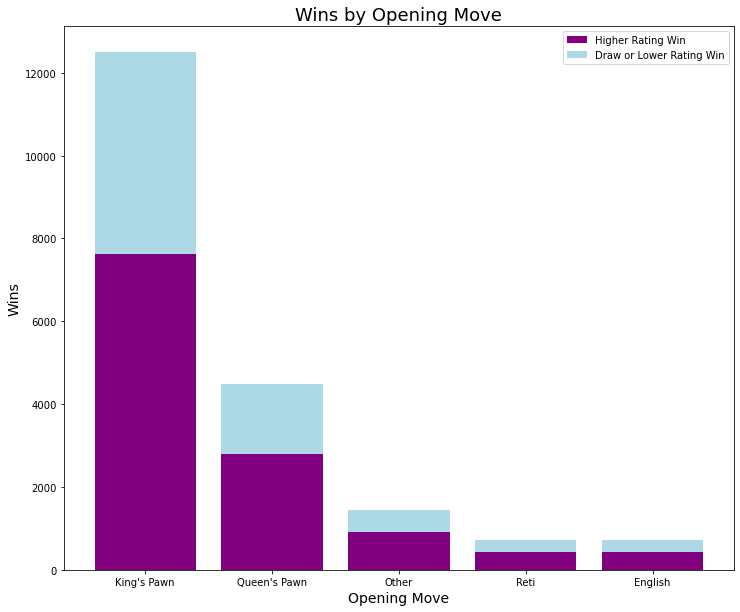

In [21]:
#Visualize which ratings dominate which opening
df_grouped_ratings = df_grouped_ratings.sort_values('totals', ascending=False)
fig, ax = plt.subplots(1, figsize=(12,10))

ax.bar([0,1,2,3,4], df_grouped_ratings['higher_rated_victory'], 
       label='Higher Rating Win', 
       color='purple', 
       tick_label=df_grouped_ratings.index)
ax.bar([0,1,2,3,4], df_grouped_ratings['losses_or_draws'], 
       label='Draw or Lower Rating Win', 
       bottom=df_grouped_ratings['higher_rated_victory'], 
       color='lightblue')

ax.set_ylabel('Wins', fontsize=14)
ax.set_xlabel('Opening Move', fontsize=14)
ax.set_title('Wins by Opening Move', fontsize=18)
ax.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

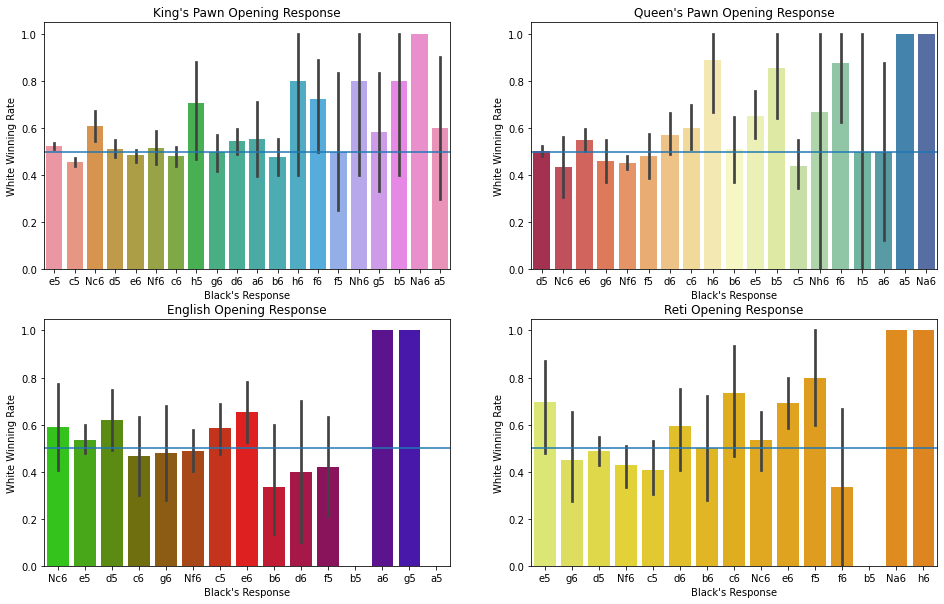

<Figure size 432x288 with 0 Axes>

In [8]:
plt.clf()
pie, axs = plt.subplots(2,2, figsize=[16,10])

plt.subplot(2,2,1)
sns.barplot(
    data=kings_pawn,
    x='response',
    y='white_victory',
)
plt.title('King\'s Pawn Opening Response')
plt.ylabel('White Winning Rate')
plt.xlabel('Black\'s Response')
plt.axhline(0.5)

plt.subplot(2,2,2)
sns.barplot(
    data=queens_pawn,
    x='response',
    y='white_victory',
    palette='Spectral'
)
plt.title('Queen\'s Pawn Opening Response')
plt.ylabel('White Winning Rate')
plt.xlabel('Black\'s Response')
plt.axhline(0.5)

plt.subplot(2,2,3)
sns.barplot(
    data=english,
    x='response',
    y='white_victory',
    palette='brg_r'
)
plt.title('English Opening Response')
plt.ylabel('White Winning Rate')
plt.xlabel('Black\'s Response')
plt.axhline(0.5)

plt.subplot(2,2,4)
sns.barplot(
    data=reti,
    x='response',
    y='white_victory',
    palette='Wistia'
)
plt.title('Reti Opening Response')
plt.ylabel('White Winning Rate')
plt.xlabel('Black\'s Response')
plt.axhline(0.5)

plt.show()
plt.clf()

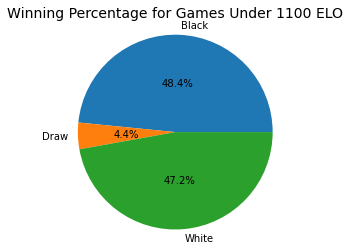

In [9]:
#Create desired dataframe where every player is rated under a certain ELO

#This mainly became a cell for me to mess around with the numbers a bit then
#see how it affected the pie chart
num = 1100
df_under_num = df[(df.white_rating < num) & (df.black_rating < num)]

df_under_num_winners = df_under_num.groupby('winner')['game_id'].count()
df_under_num_winners

plt.pie(x=df_under_num_winners, autopct="%.1f%%", labels=df_under_num_winners.keys(), pctdistance=0.5)
plt.title("Winning Percentage for Games Under {} ELO".format(num), fontsize=14)
plt.axis('equal')
plt.show()

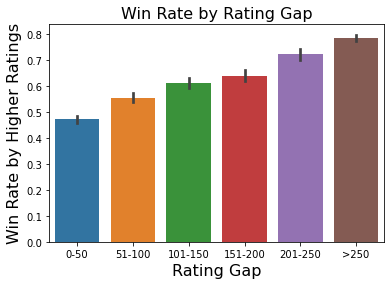

<Figure size 432x288 with 0 Axes>

In [10]:
sns.barplot(
    data=df,
    x='rating_gap_class',
    y='higher_rated_victory',
    order=['0-50', '51-100', '101-150', '151-200', '201-250', '>250']
)
plt.xlabel('Rating Gap', fontsize=16)
plt.ylabel('Win Rate by Higher Ratings', fontsize=16)
plt.title('Win Rate by Rating Gap', fontsize=16)
plt.show()
plt.clf()

In [11]:
# Get a DataFrame of all users who played white pieces and how many wins they accrued
df_users_white = df.groupby('white_id',as_index=False).agg({'white_victory':'sum', 'game_id':'count'})
df_users_white.rename(columns={'white_victory':'white_victories', 'game_id':'white_games'}, inplace=True)
df_users_white = df_users_white.set_index('white_id')

# Get a DataFrame of all users who had black pieces and how many victories their opponents accrued
df_users_black = df.groupby('black_id',as_index=False).agg({'white_victory':'sum', 'game_id':'count'})
df_users_black.rename(columns={'white_victory':'white_victories', 'game_id':'black_games'}, inplace=True)
df_users_black = df_users_black.set_index('black_id')

# Since we only know white piece victories, we need black piece victories to give us the number of games won by the key
df_users_black['black_victories'] = df_users_black.black_games - df_users_black.white_victories
df_users_black.drop('white_victories', axis=1, inplace=True)

# Join the two dataframes together on the index (username in this case). Some will have NaN values because of the nature of the join
# But we can just replace those with 0
df_users = df_users_white.join(df_users_black)
df_users = df_users.fillna(0)

# add columns for total victories and total games played
df_users['victories'] = df_users.white_victories + df_users.black_victories
df_users['games_played'] = df_users.white_games + df_users.black_games

# Now that we have total number of wins and games played, how about winning percentage?
df_users['win_pct'] = df_users.victories / df_users.games_played


# Let's sort the df by people who have the highest win percentage
df_users_sorted = df_users.sort_values(by=['win_pct'], ascending=False)
df_users_sorted.head(5)

,white_victories,white_games,black_games,black_victories,victories,games_played,win_pct
white_id,,,,,,,
rahza,1,1,0.0,0.0,1.0,1.0,1.0
houdini1ply,2,2,0.0,0.0,2.0,2.0,1.0
pakz91,1,1,0.0,0.0,1.0,1.0,1.0
holger1111,1,1,0.0,0.0,1.0,1.0,1.0
hola_yehmi,1,1,0.0,0.0,1.0,1.0,1.0


In [12]:
game_threshold = 24
df_users_many_games = df_users[(df_users.games_played >= game_threshold)]
df_users_many_games_sorted = df_users_many_games.sort_values(by=['win_pct'], ascending=False)
df_users_many_games_sorted.head(10)

,white_victories,white_games,black_games,black_victories,victories,games_played,win_pct
white_id,,,,,,,
chesswithmom,14,14,10.0,10.0,24.0,24.0,1.000000
siindbad,13,13,13.0,13.0,26.0,26.0,1.000000
smartduckduckcow,3,3,21.0,21.0,24.0,24.0,1.000000
chesscarl,18,18,28.0,27.0,45.0,46.0,0.978261
lzchips,12,13,13.0,13.0,25.0,26.0,0.961538
christina-a-11,14,15,11.0,11.0,25.0,26.0,0.961538
smilsydov,15,16,22.0,21.0,36.0,38.0,0.947368
doraemon61,18,19,23.0,21.0,39.0,42.0,0.928571
gmanderson,12,12,12.0,10.0,22.0,24.0,0.916667


In [13]:
#Get a DataFrame containing all of the games chesscarl played
df_carl = df[(df.white_id == 'chesscarl') | (df.black_id == 'chesscarl')]
df_carl.rated.unique()

array([ True])

In [14]:
#Get all the unique ids in the games chesscarl has played
print(df_carl.white_id.unique())
print(df_carl.black_id.unique())

['chilon' 'loebas' 'thelordoftheboard' 'lebbeusz2450' 'chesscarl'
 'angel2006' 'aca021' 'rigoberto_22' 'heisenberg3' 'vchess4' 'slobodan7'
 'fire_on_the_board' 'rodrigo-sagastegui' 'bdoq' 'hayki34' 'klemi'
 'mavrincbor' 'peshkach' 'ibonuribeetxebarria' 'foucheval' 'comped'
 'bshma' 'thorfabian' 'oilen1401' 'mahyir35' 'superii']
['chesscarl' 'christopho' 'kiterdekel' 'a_b_d_o' 'angel2006'
 'mario-panagiotis' 'grosschess' 'danielsor' 'sergey197316' 'anna1605'
 'wevertonsoares' 'withouttroble' 'g_king' 'krembrule' 'grewia'
 'ratnikmora' 'just_emza' 'gfinch' 'mahyir35']


In [15]:
#In how many games was chesscarl the higher-rated player? Adding a column to tell us whether they were or not
#This gives me an error but I'm going to ignore it for now even though it's really annoying...
df_carl['carl_higher'] = np.where((df_carl['white_id'] == 'chesscarl') & (df_carl['white_rating'] > df_carl['black_rating']) | (df_carl['black_id'] == 'chesscarl') & (df_carl['black_rating'] > df_carl['white_rating']), 1, 0)

#df_carl[['white_id', 'white_rating', 'black_id', 'black_rating', 'carl_higher', 'rating_gap']].head(10)

#We can get the number of games that chesscarl was rated higher than their opponents by using the .sum() function on the dataframe
num_carl_higher = df_carl.carl_higher.sum()
print('Chesscarl is a higher rating in', num_carl_higher, 'of their', len(df_carl), 'games.')

Chesscarl is a higher rating in 43 of their 46 games.


C:\Users\meinzecp\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
df_carl_is_higher = df_carl[(df_carl.carl_higher == 1)]
df_carl_is_lower = df_carl[(df_carl.carl_higher == 0)]

print('Average rating above opponents when higher-rated:', df_carl_is_higher.rating_gap.mean())
print('Average rating below opponents when lower-rated:', df_carl_is_lower.rating_gap.mean())

Average rating above opponents when higher-rated: 355.48837209302326
Average rating below opponents when lower-rated: 68.0


In [17]:
def get_engine_similarity(df, username, top_moves_num=3):
    # create an empty list to store the similarity between chesscarl's moves and a 2600-rated engine's top 3 moves
    # I will store the similarity in percentages for each game
    engine_pct = []
    df_white = df[(df.white_id == username)]
    df_black = df[(df.black_id == username)]
    
    # loop through the moves in each white game, comparing to top engine moves
    for index, row in df_white.iterrows():
        similar_moves = 0
        moves_list = row['moves_list'] # get moves made by specified user
        board = chess.Board()
        for i in range(len(moves_list)):
            if i % 2 == 0:
                stockfish = Stockfish('C:/Users/meinzecp/Downloads/stockfish_14.1_win_x64_avx2/stockfish_14.1_win_x64_avx2.exe')
                stockfish.set_fen_position(board.fen()) #updates the current board position for stockfish
                engine_moves = stockfish.get_top_moves(top_moves_num) #returns a list of dictionaries containing the top moves
                
                # get the fen notation for the move made by the specified user
                board.push_san(moves_list[i])
                fen1 = board.fen()
                board.pop()
                # get the fen notation for all of the top moves and compare it to the fen notation of the move made by the user
                for dic in engine_moves:
                    board.push_san(dic['Move'])
                    fen2 = board.fen()
                    board.pop()
                    if fen1 == fen2:
                        similar_moves = similar_moves + 1 # add 1 to counter if fen position of engine = fen position of user
                board.push_san(moves_list[i]) # make white move
            else:
                board.push_san(moves_list[i]) # make black move (no need to compare these moves to the engine)
        similarity_pct = similar_moves / math.ceil(len(moves_list)/2)
        engine_pct.append(similarity_pct)
    
    # loop through the moves in each black game, comparing to top engine moves
    for index, row in df_black.iterrows():
        similar_moves = 0
        moves_list = row['moves_list']
        board = chess.Board()
        for i in range(len(moves_list)):
            if i % 2 == 1:
                stockfish = Stockfish('C:/Users/meinzecp/Downloads/stockfish_14.1_win_x64_avx2/stockfish_14.1_win_x64_avx2.exe')
                stockfish.set_fen_position(board.fen())
                engine_moves = stockfish.get_top_moves(top_moves_num)
                board.push_san(moves_list[i])
                fen1 = board.fen()
                board.pop()
                for dic in engine_moves:
                    board.push_san(dic['Move'])
                    fen2 = board.fen()
                    board.pop()
                    if fen1 == fen2:
                        similar_moves = similar_moves + 1
                board.push_san(moves_list[i])
            else:
                board.push_san(moves_list[i])
        similarity_pct = similar_moves / math.floor(len(moves_list)/2)
        engine_pct.append(similarity_pct)
    
    return engine_pct

In [18]:
chesscarl_game_engine_analysis = get_engine_similarity(df, 'chesscarl', 4)
print(chesscarl_game_engine_analysis)

[1.0, 0.72, 0.9090909090909091, 1.0, 0.9523809523809523, 1.0, 0.9565217391304348, 0.7096774193548387, 0.9, 0.9047619047619048, 0.8571428571428571, 0.8, 0.8857142857142857, 0.9285714285714286, 0.8620689655172413, 0.9375, 0.9615384615384616, 0.9285714285714286, 0.8837209302325582, 0.896551724137931, 0.96, 0.9354838709677419, 0.9285714285714286, 0.9166666666666666, 1.0, 1.0, 0.7857142857142857, 0.8918918918918919, 0.7916666666666666, 0.8666666666666667, 0.9166666666666666, 0.9230769230769231, 0.9411764705882353, 0.8928571428571429, 0.9722222222222222, 0.7894736842105263, 0.75, 0.9130434782608695, 0.9090909090909091, 0.74, 1.0, 0.9166666666666666, 0.88, 0.8490566037735849, 0.9090909090909091, 0.6666666666666666]


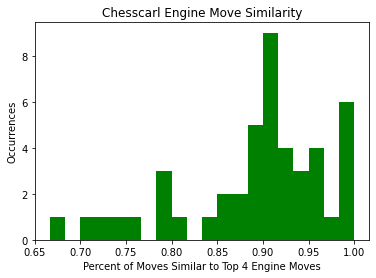

In [22]:
plt.hist(chesscarl_game_engine_analysis, bins=20, color='green')
plt.xlabel('Percent of Moves Similar to Top 4 Engine Moves')
plt.ylabel('Occurrences')
plt.title('Chesscarl Engine Move Similarity')
plt.show()

Looking at the histogram, we can see that in each game chesscarl played, at least 60% of their moves were similar to a top-4 engine move in each game, according to stockfish 14. In some games, although we don't know the length of the games from looking at the histogram, chesscarl matched the top four engine moves 100%.

Again, since we concluded that chesscarl was just playing against lower-rated players in nearly every game, it's not hard to find top moves in that scenario. But now that I have this function, I can take a look at the accuracy of any player I choose to determine how accurate they are with respect to engines. It's not a perfect system like chess.com's accuracy percentage, but it does what I want it to do.